In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import re
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from tqdm import tqdm
import gensim, logging
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Show distribution of target values

We notice that there are more examples of no disaster tweets, rather than disaster tweets.

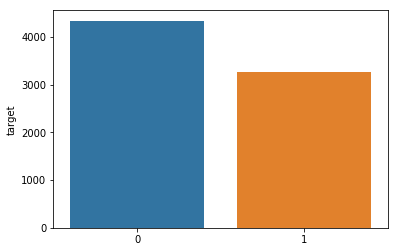

In [3]:
sns.barplot(train.target.value_counts().index, train.target.value_counts())

### Show distribution of tweet character lengths in disaster vs non disaster tweets

We note here that these distributions are similar

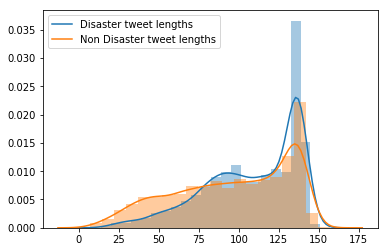

In [4]:
disaster_tweet_lengths = list(map(lambda x : len(x), train[train['target'] == 1]['text']))
no_disaster_tweet_lengths = list(map(lambda x : len(x), train[train['target'] == 0]['text']))

sns.distplot(disaster_tweet_lengths, kde_kws={"label": "Disaster tweet lengths"})
sns.distplot(no_disaster_tweet_lengths, kde_kws={"label": "Non Disaster tweet lengths"})

### Show distribution of word length in disaster vs non disaster tweets

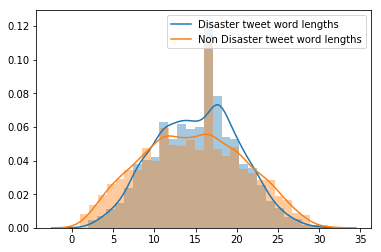

In [5]:
disaster_tweet_word_lengths = list(map(lambda x : len(x.split()), train[train['target'] == 1]['text']))
no_disaster_tweet_word_lengths = list(map(lambda x : len(x.split()), train[train['target'] == 0]['text']))
sns.distplot(disaster_tweet_word_lengths, kde_kws={"label": "Disaster tweet word lengths"})
sns.distplot(no_disaster_tweet_word_lengths, kde_kws={"label": "Non Disaster tweet word lengths"})

### Create Corpus of Words

In [6]:
def corpus():
    corp = []
    for tweet in train['text']:
        for word in tweet.split():
            corp.append(word)
    return corp

### Show 20 most common words

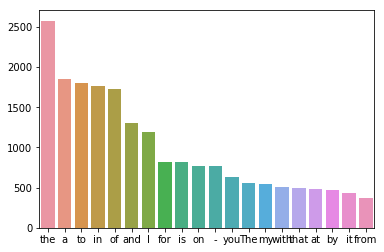

In [7]:
x_counts = []
y_counts = []
counter = Counter(corpus()).most_common(20)
for row in counter:
    x_counts.append(row[0])
    y_counts.append(row[1])
sns.barplot(x=x_counts, y=y_counts)

### Bigram Analysis

In [8]:
corp = corpus()
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(corp)

In [9]:
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

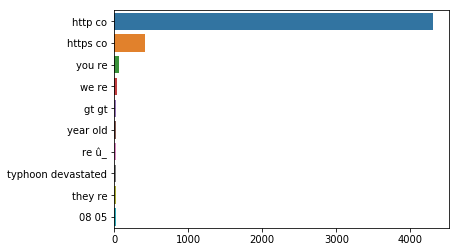

In [10]:
y = [var[0] for var in words_freq[:10]]
x = [var[1] for var in words_freq[:10]]
sns.barplot(x=x,y=y)

### Data Cleaning

In [45]:
df = train

In [46]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)


spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)




In [47]:
df['text']=df['text'].apply(lambda x: remove_url(x))
df['text']=df['text'].apply(lambda x: remove_html(x))
df['text']=df['text'].apply(lambda x: remove_emoji(x))
df['text']=df['text'].apply(lambda x: remove_punct(x))
#df['text']=df['text'].apply(lambda x: correct_spellings(x))

In [48]:
stop=set(stopwords.words('english'))

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=' '.join([word.lower() for word in word_tokenize(tweet) if ((word.isalpha()==1) & (word not in stop))])
        corpus.append(words)
    return corpus

In [49]:
corp = create_corpus(df)

100%|██████████| 7613/7613 [00:01<00:00, 7112.16it/s]


### Visualize PCA Componenets

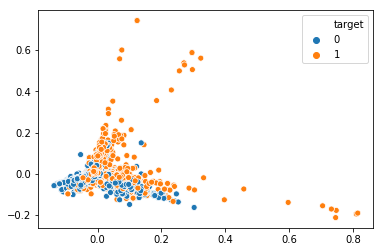

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=df['target'])

### Convert documents into Tfidf vectors

In [53]:
vectorizer = TfidfVectorizer(min_df=2)
vectorizer.fit(corp)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [59]:
X = vectorizer.transform(corp).toarray()
X.shape

(7613, 6198)

### Classify Tfidf vectors using Logistic Regression

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, df['target'], test_size=0.25, random_state=42)

In [61]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#clf = MultinomialNB()
# clf.fit(X_train, y_train)

In [57]:
clf.score(X_test, y_test)

0.8119747899159664

### Final Model

In [62]:
df2 = test
df2['text']=df2['text'].apply(lambda x: remove_url(x))
df2['text']=df2['text'].apply(lambda x: remove_html(x))
df2['text']=df2['text'].apply(lambda x: remove_emoji(x))
df2['text']=df2['text'].apply(lambda x: remove_punct(x))
test_corp = create_corpus(df2)

X_final = vectorizer.transform(test_corp).toarray()
X_final.shape

100%|██████████| 3263/3263 [00:00<00:00, 7252.64it/s]


(3263, 6198)

In [63]:
clf = LogisticRegression(random_state=0).fit(X, df['target'])


### Submission

In [66]:
sample_sub=pd.read_csv('sample_submission.csv')
y_pre=clf.predict(X_final)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

## Sources

I used code and inspiration from these notebooks:

#### NLP - EDA, Bag of Words, TF IDF, GloVe, BERT
https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

#### Basic EDA,Cleaning and GloVe
https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove